# GNSSREFL parsers

GNSSREFL parsers can be used to read results files of the GNSS Interferometric Reflectometry (GNSS-IR) software [gnssrefl](https://github.com/kristinemlarson/gnssrefl). 

Midgard provides following parsers for reading certain GNSSREFL formats:

| Parser name           | Description                        |
| :-------------------- | :--------------------------------- |
| gnssrefl_allrh        | A parser for reading GNSSREFL reflector height timeseries files |
| gnssrefl_snr          | A parser for reading GNSSREFL SNR files | 
| gnssrefl_txt          | A parser for reading daily GNSSREFL reflector height results (output of 'gnssir' and 'subdaily' program) |

## Use of gnssrefl_txt parser

An example is shown, how to use the **gnssrefl_txt** parser:

In [17]:
# Import parsers package
from midgard import parsers

# Read file by generating an instance of a Parser class
p = parsers.parse_file(parser_name="gnssrefl_txt", file_path="../examples/parsers/ande_2025_subdaily_edit.txt.withrhdotIF")

# Generate dataset based on read file data
dset = p.as_dataset()

**dset** is a Midgard dataset with following data fields, which represents a column in the dataset:

| Parameter                 | Description                                                                     |
| :------------------------ | :------------------------------------------------------------------------------ |
| amplitude                 | Amplitude                                                                       |
| azimuth                   | Azimuth in [deg]                                                                |
| elevation_max             | Maximal elevation [deg]                                                         |
| elevation_min             | Minimal elevation [deg]                                                         |
| elevation_rate            | Elevation rate [rad/hour]                                                       |
| frequency                 | GNSS frequency identifier                                                       |
| interfreq_bias_correction | Interfrequency bias correction in [m] (Note: Information added to data.)        |
| number_of_observation     | Number of SNR observation                                                       |
| peak2noise                | Peak to noise (maximal amplitude/noise)                                         |
| reflector_height          | Reflector height in [m]                                                         |
| reflector_height_with_    | Reflector height with interfrequency corrections in [m]                         |
|  interfreq_corr           |                                                                                 |
| reflector_height_with_    | Reflector height with time varying height corrections (RHDOT) in [m]            | 
|  rhdot_corr               |                                                                                 |
| refraction_model          | Defining used refraction model                                                  |
|                           |    0: No refraction correction applied                                          |
|                           |    1: Standard Bennett refraction correction                                    |
|                           |    2: Standard Bennett refraction correction, time-varying                      |
|                           |    3: Ulich refraction correction                                               |
|                           |    4: Ulich refraction correction, time-varying                                 |
|                           |    5: NITE refraction correction (Peng et al.)                                  |
|                           |    6: MPF refraction correction, Wiliams and Nievinski                          |
| rhdot_correction          | Time varying height corrections (RHDOT) in [m]                                  |
| rising_satellite          | Rising satellite is set to 1 and setting satellite to -1                        | 
| satellite                 | Satellite number                                                                |
| satellite_arc_length      | Satellite arc length in [min]                                                   |
| time                      | Time as datetime object                                                         |

In [18]:
# Show dataset fields
dset.fields

['amplitude',
 'azimuth',
 'elevation_max',
 'elevation_min',
 'elevation_rate',
 'frequency',
 'interfreq_bias_correction',
 'number_of_observation',
 'peak2noise',
 'reflector_height',
 'refraction_model',
 'rhdot_correction',
 'rising_satellite',
 'satellite',
 'satellite_arc_length',
 'system',
 'time']

In the following it is shown how to plot the GNSSREFL solution:

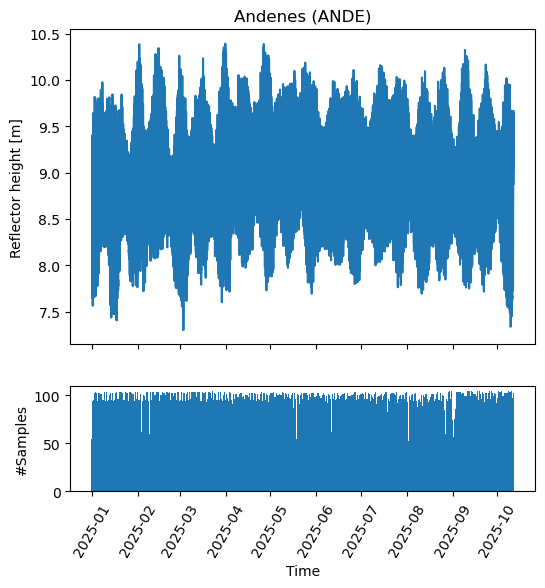

In [19]:
import matplotlib.pyplot as plt

fig, (ax_top, ax_bot) = plt.subplots(
                            2, 1, 
                            figsize=(6,6), 
                            gridspec_kw={'height_ratios': [3, 1]},
                            sharex=True,
)
plt.xticks(rotation=60)

ax_top.set_title("Andenes (ANDE)")
ax_top.plot(dset.time.datetime, dset.reflector_height)
ax_top.set_ylabel("Reflector height [m]")

ax_bot.bar(dset.time.datetime, dset.number_of_observation)
ax_bot.set_xlabel("Time")
ax_bot.set_ylabel("#Samples")
plt.show()

#### Convert reflector height to ITRF2014 (current epoch)
In the following the steps are shown how to convert reflector height to ITRF2014 (current epoch) and a mean-tide Earth tide system. As an example the GNSS station **Andenes (ANDE)** is used.

In [86]:
# Standard library imports
from datetime import datetime

# Third party imports
import matplotlib.pyplot as plt
import numpy as np

# Midgard imports
from midgard import parsers
from midgard.api import transformation_api, water_level_api
from midgard.data.position import Position, PositionDelta
from midgard.dev import log
from midgard.gnss.antenna_calibration import AntennaCalibration
from midgard.math import spatial_interpolation
from midgard.math.unit import Unit

# Define input parameters for Andenes GNSS station
date_from = datetime(2025, 1, 1)
date_to = datetime(2025, 12, 2)
latitude = 69.32605478540711 # in [deg] related to EUREF89 for GNSS station ANDE
longitude = 16.134811856968703 # in [deg] related to EUREF89 for GNSS station ANDE
height = 44.22554720811418 # in [m] related to EUREF89 for GNSS station ANDE
epoch_current = 2025.6
antenna_type = "TRM55971.00"
radome_type = "NONE"

# Initialize logging information
#
# Note: If logging module is not initialized, then the additional logging information are not printed.
log.init(log_level="info")

# Define spatial interpolation function used later in the notebook
def grid_interpolation(file_path, latitude, longitude):
    """Spatial interpolation based on GRAVSOFT grid file

    Args:
        file_path: File path of GRAVSOFT grid file
        Latitude:  Latitude in [deg]
        Longitude:  Longitude in [deg]

    Returns:
        Interpolated value based on given grid information
    """
    p = parsers.parse_file(parser_name="gravsoft_grid", file_path=file_path)
    data = p.as_dict()
    
    # Arrange grid data for spatial interpolation
    num_rows = len(data["latitude"])
    num_cols = len(data["longitude"])
    grid_lon = np.repeat([data["longitude"]], num_rows, axis=0)
    grid_lat = np.repeat(np.array([data["latitude"]]).T, num_cols, axis=1)
    
    value = spatial_interpolation.interpolate(
                grid_x = grid_lon, 
                grid_y = grid_lat, 
                values = data["data"], 
                x = longitude, 
                y = latitude,
                kind = "regular_grid_interpolator",
    )

    return value[0]


# Define GNSS antenna phase center offset function used later in the notebook
def antenna_phase_center_offset(dset, ref_pos, antenna_type, radome_type, use_gps_l1=False):
    """Get antenna phase center offset for receiver height

    Args: 
        dset:          A dataset containing the data
        ref_pos:       Reference position given as Position object
        antenna_type:  Antenna type name 
        radome_type:   Radome type name
        use_gps_l1:    Use for GNSS frequency GPS L1 phase center offsets
    """ 
    alternative_freq = {
            "C": "B1C",
            "E": "E1",    
            "G": "L1",
            "R": "G1",
    }
    pco_rcv_all = np.zeros((dset.num_obs,3))
    
    ant_cal = AntennaCalibration(file_path="../examples/parsers/igs20_trm55971_none.atx")

    for sys in dset.unique("system"):
        idx_sys = dset.filter(system=sys)
            
        for freq in set(dset.frequency[idx_sys]):
            
            idx_freq = dset.filter(frequency=freq, idx=idx_sys)
    
            # Get antenna phase center offset of receiver
            if use_gps_l1:
                sys = "G"
                freq = "L1"
                
            try:
                pco_rcv = ant_cal.get_pco_rcv(sys, freq, antenna_type, radome_type)
            except ValueError:
                log.warn(f"Frequency {sys}:{freq} is not included in antenna calibration for "
                         f"antenna '{antenna_type.strip()} {radome_type}'. Therefore phase center offset for frequency "
                         f"{sys}:{alternative_freq[sys]} is chosen.")
                pco_rcv = ant_cal.get_pco_rcv(sys, alternative_freq[sys], antenna_type, radome_type)
        
            log.debug(f"Antenna phase center offset for antenna '{antenna_type} {radome_type}' and frequency "
                     f"{sys}:{freq} (or alternative frequency): North: {pco_rcv[0]:.5f} East: {pco_rcv[1]:.5f} Up: "
                     f"{pco_rcv[2]:.5f} in [m]")
            
            pco_rcv_all[idx_freq] = [pco_rcv[1], pco_rcv[0], pco_rcv[2]] 

    dset.add_position_delta(
                "pco_rcv", 
                val=pco_rcv_all, 
                system="enu", 
                ref_pos=ref_pos,
    )

    return pco_rcv

##### 2. Convert EUREF89 coordinates to ITRF2014 epoch 2010.0 by using Midgard wrapper around transformation API

In [87]:
# Get instance of TransformationApi class with transformation API methods
api = transformation_api.TransformationApi()

lon_arp_itrf2014, lat_arp_itrf2014, h_arp_itrf2014_tf = api.transform(
            x = longitude,
            y = latitude,
            z = height,
            t = epoch_current,
            from_epsg = 4937,  # EPSG code for geodetic 3D coordinate system for EUREF89
            to_epsg = 7912,  # EPSG code geodetic 3D coordinate system for ITRF2014
)

log.info(f"Height of ANDE in ITRF2014 epoch 2010.0: {h_arp_itrf2014_tf:.3f} m")

INFO  Height of ANDE in ITRF2014 epoch 2010.0: 44.280 m


##### 3. Convert tide gauge zero from tide-free to mean-tide system
Height and gravity observations include permanent tidal effects. These observations are related to different tidal systems in dependency of applied tide corrections. It is distinguished between three tidal systems:
- **non-tidal**/**tide-free**: All tidal effects are eleminated from the Earth's shape, that means both the direct tidal attractions of external bodies (the Moon, the Sun, and the planets) and the Earth's elastic response (indirect effect).
    *Example: ITRF solutions, TGZ height*
- **mean-tide**: The permanent tidal effect is kept by the shape of the Earth.
    *Example: Altimetry satellite sea surface heights, tide gauge water level*
- **zero-tide**: It eliminates the direct effect from the Earth's shape, but keeps the indirect effect.
    *Example: NN2000*

In [88]:
# Convert height of ANDE from tide-free to mean-tide system

# 1. Method is based on:
# "Systemer for permanent tidejordeffekt" section in K. Breili et al., Felles referanseramme for sjø og land - fase 2, 2020, Rapport 19-04811-3
sin_lat = (1/3 - np.sin(latitude*Unit.deg2rad)**2)
h_arp_itrf2014_mt = h_arp_itrf2014_tf + 0.180923826 * sin_lat * (1 + 0.00124 * sin_lat)

# 2. Method is based on:
# "Tidal Systems" section by J. Mäkinen in M. G. Sideris (ed.), Encyclopedia of Geodesy, Encyclopedia of Earth Sciences Series, 2025
# https://doi.org/10.1007/978-3-319-02370-0_70-1
sin_lat = np.sin(latitude * Unit.deg2rad)
h_arp_itrf2014_mt2 = h_arp_itrf2014_tf + (60.34 - 179.01 * sin_lat**2 - 1.82 * sin_lat**4) * Unit.mm2m
log.info(f"Height of ANDE in ITRF2014 epoch 2010.0 and mean-tide system: {h_arp_itrf2014_mt:.3f} m/{h_arp_itrf2014_mt2:.3f} m")

INFO  Height of ANDE in ITRF2014 epoch 2010.0 and mean-tide system: 44.182 m/44.183 m


##### 4. Refer reflector height to ARP

In [89]:
# Read file by generating an instance of a Parser class
p = parsers.parse_file(parser_name="gnssrefl_txt", file_path="../examples/parsers/ande_2025_subdaily_edit.txt.withrhdotIF")

# Generate dataset based on read file data
dset = p.as_dataset()

# Define reference position as Position object
pos_arp = Position(
            val=[lat_arp_itrf2014 * Unit.deg2rad, lon_arp_itrf2014 * Unit.deg2rad, h_arp_itrf2014_mt],
            system="llh",
)

# Get antenna phase center offset in dependency of GNSS frequency
antenna_phase_center_offset(dset, pos_arp, antenna_type, radome_type, use_gps_l1=True)

# Convert reflector height related to APC to ARP by using PCOs
rh_arp = dset.reflector_height - dset.pco_rcv.enu.up

##### 5. Determine elliposoidal reflector height

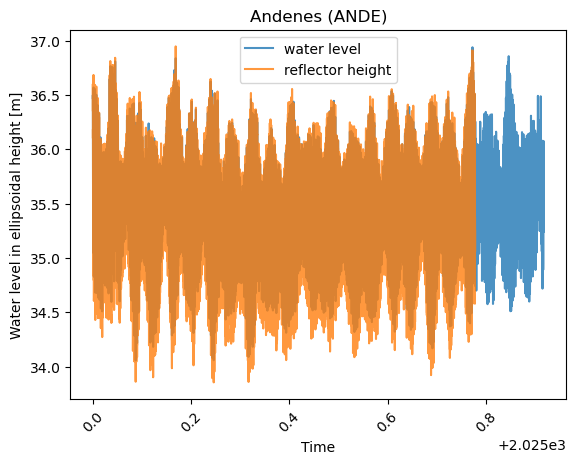

Water level
mean: 35.430 +/- 0.523 [m]
max:  36.938 [m]
min:  34.057 [m]

Reflector height
mean: 35.322 +/- 0.539 [m]
max:  36.947 [m]
min:  33.855 [m]

Offset between water level and reflector height: 0.108 [m]



In [91]:
# Determine elliposoidal reflector height
#
# Note: GNSS-IR tide-free solution given better results compared to water level mean-tide solution than the 
#       GNSS-IR mean-tide solution. This is not expected. Are the caculation steps correct?
#rh_itrf2014 = h_arp_itrf2014_mt - rh_arp 
rh_itrf2014 = h_arp_itrf2014_mt - rh_arp

# Read water level data for tide gauge Andenes (ANX) for comparison
wl_data = np.genfromtxt(
    "../examples/parsers/ande_water_level.csv",
    delimiter=",",
    names=True,
)

# Plot data
plt.plot(
        wl_data["time"], 
        wl_data["water_level"],
        label="water level",
        alpha=0.8,
)

plt.plot(
        dset.time.decimalyear, 
        rh_itrf2014, 
        label="reflector height",
        alpha=0.8,
)
plt.title(
    f"Andenes (ANDE)"
)
plt.xlabel("Time")
plt.ylabel("Water level in ellipsoidal height [m]")
plt.xticks(rotation=45) 
plt.legend()
plt.show()

# Statistic
print(f"Water level\n"
      f"mean: {wl_data["water_level"].mean():.3f} +/- {wl_data["water_level"].std():.3f} [m]\n"
      f"max:  {wl_data["water_level"].max():.3f} [m]\n"
      f"min:  {wl_data["water_level"].min():.3f} [m]\n"
)
print(f"Reflector height\n"
      f"mean: {rh_itrf2014.mean():.3f} +/- {rh_itrf2014.std():.3f} [m]\n"
      f"max:  {rh_itrf2014.max():.3f} [m]\n"
      f"min:  {rh_itrf2014.min():.3f} [m]\n"
)
print(f"Offset between water level and reflector height: "
      f"{wl_data["water_level"].mean()- rh_itrf2014.mean():.3f} [m]\n"
)